In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, LayerNormalization, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

2024-06-04 13:09:30.074851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 13:09:30.074967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 13:09:30.175075: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data preperation

In [2]:
# Step 1: Define hierarchical structure from JSON
def extract_hierarchy(interests_json):
    hierarchy = {}
    for user in interests_json:
        for level1, level2_interests in user["interests"].items():
            if level1 not in hierarchy:
                
                hierarchy[level1] = set()
            for level2 in level2_interests:
                hierarchy[level1].add(level2)
    return hierarchy

In [3]:
import json

# Load interests JSON file
with open('/kaggle/input/input/users (1).json', 'r') as f:
    users = json.load(f)

hierarchy = extract_hierarchy(users)

print(hierarchy)
# Map hierarchical labels to integers
level1_to_int = {category: idx for idx, category in enumerate(hierarchy.keys())}
level2_to_int = {subcat: idx for idx, subcats in enumerate(hierarchy.values()) for subcat in subcats}
print("level 1 : ",level1_to_int)
print("level 2 : ",level2_to_int)

{'Business and Industry': {'social media', 'Health care', 'Business'}, 'family and relationships': {'parenting', 'dating and mariage', 'family'}, 'fitness and wellness': {'yoga', 'running', 'Physical exercise', 'bodybuilding'}, 'shopping and fashion': {'toys', 'fashion accessories', 'shopping', 'beauty', 'clothing'}, 'sports': {'golf', 'Auto racing', 'american football', 'baseball', 'volleyball', 'marathon', 'handball', 'swimming', 'skiing', 'basketball', 'tennis', 'football/soccer'}, 'Entertainment': {'reading', 'music', 'live events', 'tv and series', 'movies', 'Games'}, 'hobbies and activities': {'pets', 'current event homes and garden', 'political and socials issues', 'travel', 'art and music', 'vehicles'}, 'Technology': {'computers', 'consumer electronics'}, 'food and drink': {'cooking and cuisine', 'food and restaurant', 'alcoholic beverage', 'beverages'}, 'Outdoors': {'camping', 'horseback riding', 'hiking', 'fishing'}}
level 1 :  {'Business and Industry': 0, 'family and relatio

In [8]:
# Load user features
with open('/kaggle/input/user-features/user_features.json', 'r') as f:
    user_features = json.load(f)

# Create a dictionary to map user IDs to their interests
user_interests_dict = {user['user_id']: user['interests'] for user in users}

X = []
Y_level1 = []
Y_level2 = []

# Combine the data
for user_id, features in user_features.items():
    X.append(features)
    interests = user_interests_dict.get(user_id, {})
    level1_labels = [0] * len(level1_to_int)
    level2_labels = [0] * len(level2_to_int)
        
    for level1, level2_interests in interests.items():
        level1_idx = level1_to_int[level1]
        level1_labels[level1_idx] = 1
        for level2 in level2_interests:
            level2_idx = list(level2_to_int.keys()).index(level2)
            level2_labels[level2_idx] = 1
        
    Y_level1.append(level1_labels)
    Y_level2.append(level2_labels)

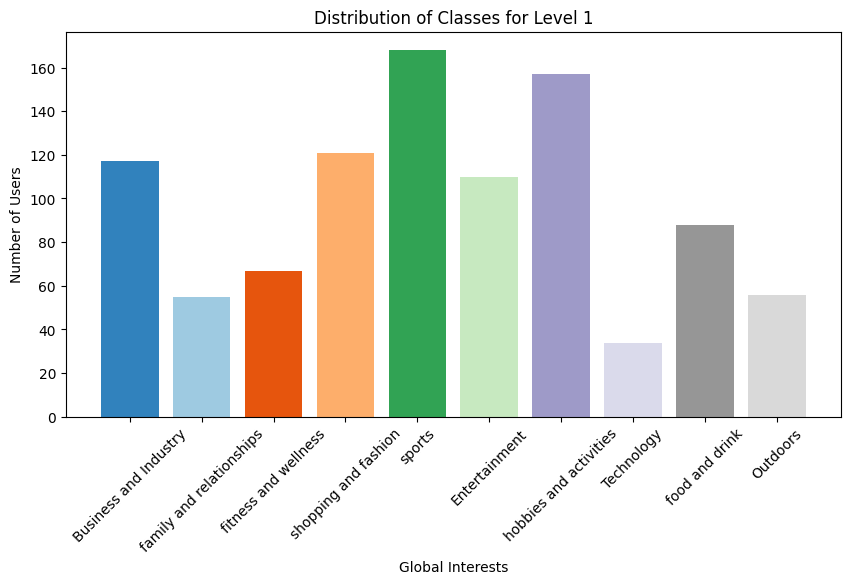

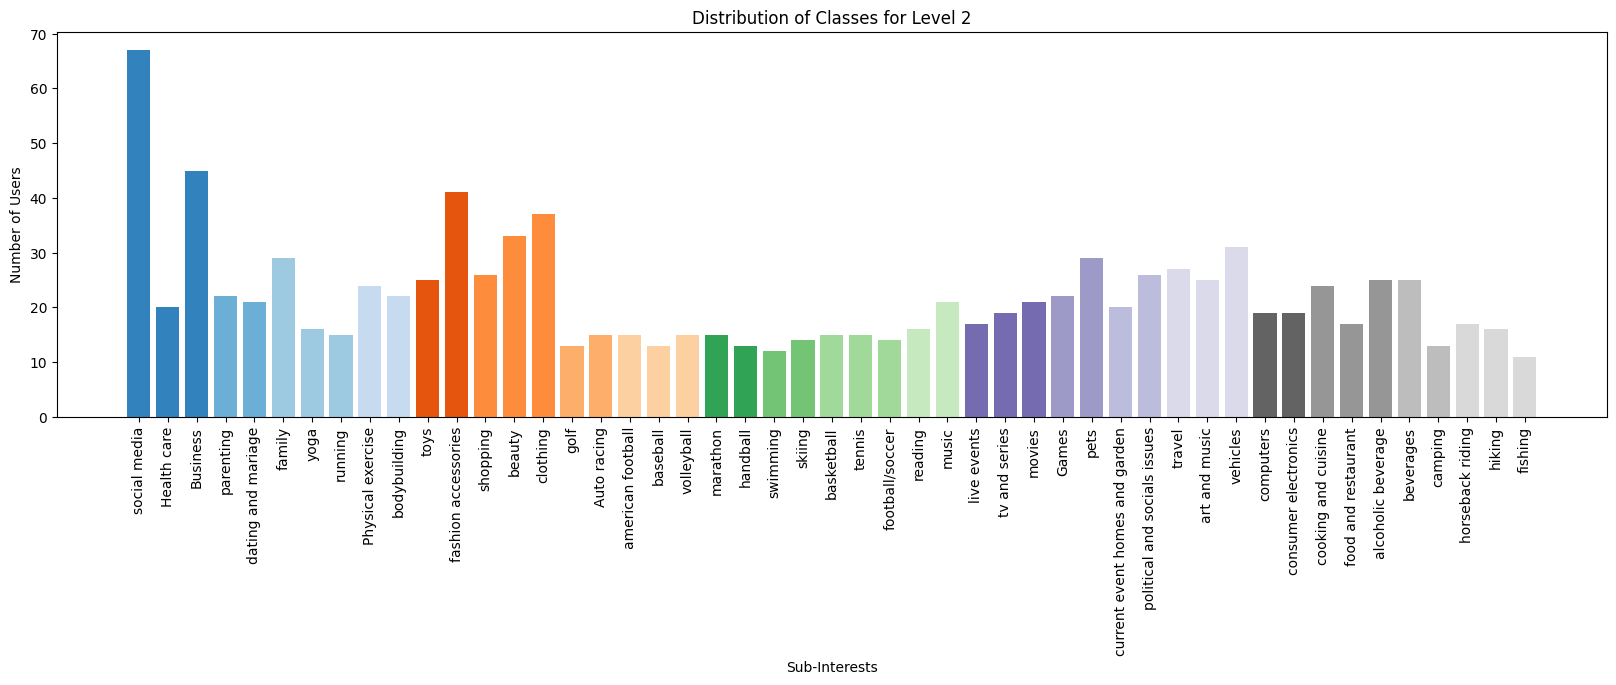

In [11]:
import matplotlib.pyplot as plt

# Plot distribution of classes for Level 1
plt.figure(figsize=(10, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, Y_level1.shape[1]))
plt.bar(level1_to_int.keys(), np.sum(Y_level1, axis=0), color=bar_colors)
plt.xlabel('Global Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 1')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of classes for Level 2
plt.figure(figsize=(20, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, Y_level2.shape[1]))
plt.bar(level2_to_int.keys(), np.sum(Y_level2, axis=0), color=bar_colors)
plt.xlabel('Sub-Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 2')
plt.xticks(rotation=90)
plt.show()


In [10]:
X = np.array(X)
Y_level1 = np.array(Y_level1)
Y_level2 = np.array(Y_level2)
X = np.squeeze(X, axis=1)

In [12]:
print(X[0])
print(Y_level1[1])
print(Y_level2[1])

[ 0.88586098  1.87482464  1.28235769  0.71928126  2.40678859  1.4906795
  0.98710191  2.01783609  1.17529821  1.72395658  3.7277801   2.61609077
  4.91477776  0.22641949  0.93853563  1.9384135   1.04617524  4.17776442
  2.10364246  8.0395174   1.94909739  3.77320552  2.42578959  3.33363128
  1.73725271  5.05924702  0.84078318  1.58074403  3.24397087  0.69922888
  5.26136398  0.65047103  1.33025682  2.32075691  3.07952142  1.68740726
  1.17352521  1.5264411   0.68434119  0.66225976  4.6623106   2.54787183
  1.51983428  1.51574278  3.26108074  1.87845552 10.61409187  4.05454111
  1.44786191  1.81808484  1.15111434  2.6717515   1.66487551  6.17037582
  1.20044434  1.54086924  8.68952274  2.26708817  3.06179523  0.90028602
  0.27051342  1.59211612  1.23566937  1.83682799  1.13772249  3.51884341
  1.52677035  1.4557457   0.71785688  1.36475897  0.362149    3.21355247
  5.51045465  0.75230372  0.41243553  4.29335451  2.45076275  1.88041198
  1.64884615  3.71668172  0.37356868  1.37099087  3.

In [13]:
from sklearn.preprocessing import normalize

# Normalize the feature vectors using L2 normalization
X = normalize(X, norm='l2')

In [14]:
print(X[0])
print(Y_level1[1])
print(Y_level2[1])

[0.01210067 0.0256097  0.01751673 0.00982523 0.03287621 0.02036236
 0.0134836  0.0275632  0.01605432 0.02354887 0.05092066 0.03573523
 0.06713479 0.00309284 0.01282019 0.02647831 0.01429053 0.05706735
 0.0287353  0.10981806 0.02662425 0.05154117 0.03313576 0.04553668
 0.02373049 0.06910821 0.01148492 0.02159262 0.04431194 0.00955131
 0.07186909 0.00888529 0.01817102 0.03170103 0.04206559 0.02304962
 0.0160301  0.02085085 0.00934795 0.00904632 0.06368615 0.03480337
 0.02076061 0.02070472 0.04454565 0.02565929 0.14498618 0.05538415
 0.01977748 0.02483464 0.01572397 0.03649554 0.02274184 0.08428599
 0.01639781 0.02104794 0.11869699 0.03096793 0.04182346 0.01229771
 0.00369515 0.02174796 0.01687897 0.02509067 0.01554104 0.04806664
 0.02085535 0.01988517 0.00980577 0.01864231 0.00494688 0.04389643
 0.07527161 0.01027631 0.00563378 0.05864629 0.03347689 0.02568602
 0.02252288 0.05076906 0.00510287 0.01872744 0.04259977 0.0815964
 0.02827432 0.02098224 0.05419667 0.0018376  0.04301182 0.07094

In [15]:
print("Shape of X:", X.shape)
print("Shape of Y_level1:", Y_level1.shape)
print("Shape of Y_level2:", Y_level2.shape)

Shape of X: (818, 512)
Shape of Y_level1: (818, 10)
Shape of Y_level2: (818, 49)


In [16]:
parent_map = [v for v in level2_to_int.values()]

# Data Augmentation

In [18]:
from collections import defaultdict

# Calculate the number of instances for each class in Level 2
class_instances = defaultdict(int)
for labels in Y_level2:
    for i, label in enumerate(labels):
        if label == 1:
            class_instances[i] += 1

max_instances = max(class_instances.values())
print(class_instances)
print(max_instances)

defaultdict(<class 'int'>, {0: 67, 2: 45, 3: 22, 5: 29, 8: 24, 11: 41, 14: 37, 26: 14, 13: 33, 1: 20, 32: 22, 28: 21, 16: 15, 38: 31, 36: 27, 12: 26, 30: 19, 4: 21, 31: 21, 29: 17, 9: 22, 15: 13, 22: 12, 25: 15, 19: 15, 21: 13, 41: 24, 6: 16, 7: 15, 20: 15, 43: 25, 44: 25, 24: 15, 40: 19, 37: 25, 27: 16, 17: 15, 18: 13, 23: 14, 34: 20, 33: 29, 45: 13, 48: 11, 46: 17, 47: 16, 39: 19, 35: 26, 10: 25, 42: 17})
67


In [19]:
type(X[0])

numpy.ndarray

In [20]:
import numpy as np

threshold = 70

# Assuming class_instances, X, Y_level1, and Y_level2 are defined earlier in the code
# Identify minor classes with fewer instances
minor_classes = [class_idx for class_idx, count in class_instances.items() if count < threshold]

# Define augmentation parameters
noise_std = 0.1  # Standard deviation of Gaussian noise
min_scale = 0.8  # Minimum scaling factor
max_scale = 1.2  # Maximum scaling factor

# Function to add Gaussian noise to a feature vector
def add_gaussian_noise(feature_vector):
    noise = np.random.normal(loc=0, scale=noise_std, size=feature_vector.shape)
    return feature_vector + noise

# Function to perform random scaling on a 1D feature vector
def random_scaling(feature_vector):
    scale_factor = np.random.uniform(min_scale, max_scale)
    scaled_vector = feature_vector * scale_factor
    return scaled_vector

# Perform data augmentation for minor classes
augmented_X = list(X)  # Start with original data
augmented_Y_level1 = list(Y_level1)
augmented_Y_level2 = list(Y_level2)

for i, x in enumerate(X):
    for j, y in enumerate(Y_level2[i]):
        if j in minor_classes and y == 1:
            # Add Gaussian noise
            augmented_feature_vector_1 = add_gaussian_noise(x)
            augmented_X.append(augmented_feature_vector_1)  # Append to the list
            augmented_Y_level1.append(Y_level1[i])
            augmented_Y_level2.append(Y_level2[i])
            
            # Random scaling
            augmented_feature_vector_2 = random_scaling(x)
            augmented_X.append(augmented_feature_vector_2)  # Append to the list
            augmented_Y_level1.append(Y_level1[i])
            augmented_Y_level2.append(Y_level2[i])

# Convert to numpy arrays
augmented_X = np.array(augmented_X)
augmented_Y_level1 = np.array(augmented_Y_level1)
augmented_Y_level2 = np.array(augmented_Y_level2)

print("Augmentation completed successfully!")


Augmentation completed successfully!


In [21]:
print("Shape of X:", augmented_X.shape)
print("Shape of Y_level1:", augmented_Y_level1.shape)
print("Shape of Y_level2:", augmented_Y_level2.shape)

Shape of X: (2962, 512)
Shape of Y_level1: (2962, 10)
Shape of Y_level2: (2962, 49)


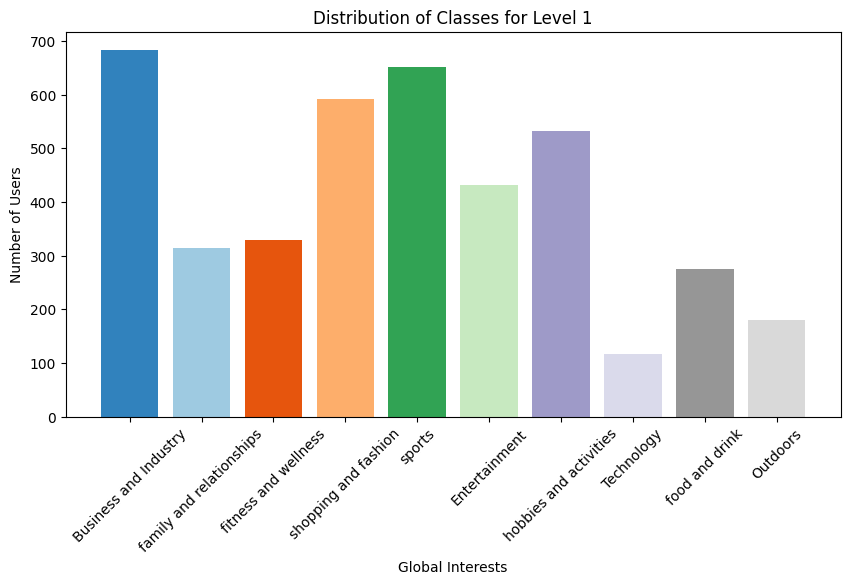

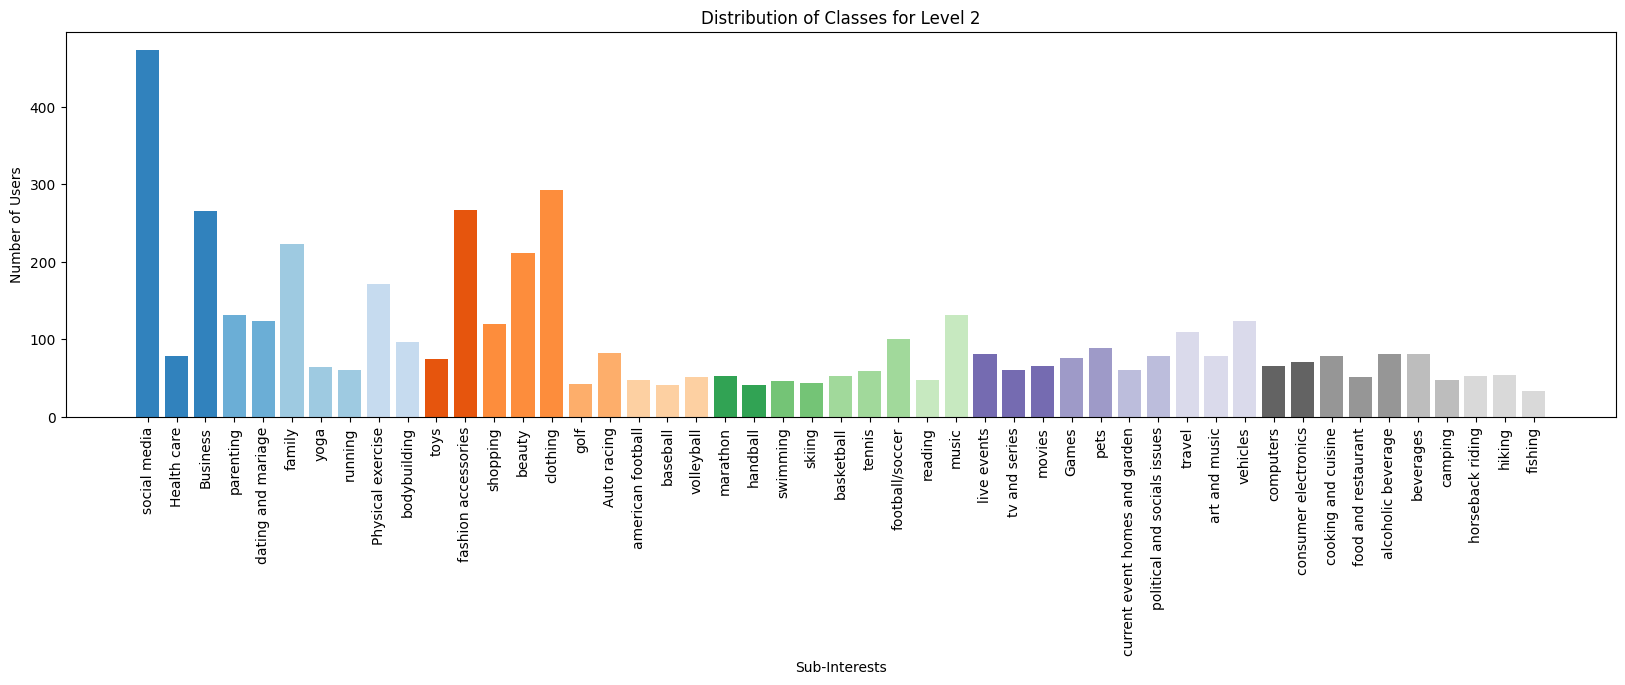

In [22]:
import matplotlib.pyplot as plt

# Plot distribution of classes for Level 1
plt.figure(figsize=(10, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, len(level1_to_int)))
plt.bar(level1_to_int.keys(), np.sum(augmented_Y_level1, axis=0), color=bar_colors)
plt.xlabel('Global Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 1')
plt.xticks(rotation=45)
plt.show()

# Plot distribution of classes for Level 2
plt.figure(figsize=(20, 5))
bar_colors = plt.cm.tab20c(np.linspace(0, 1, len(level2_to_int)))
plt.bar(level2_to_int.keys(), np.sum(augmented_Y_level2, axis=0), color=bar_colors)
plt.xlabel('Sub-Interests')
plt.ylabel('Number of Users')
plt.title('Distribution of Classes for Level 2')
plt.xticks(rotation=90)
plt.show()


# Model

In [23]:
# Split data into training, validation, and test sets while preserving class distribution
X_train, X_temp, Y_level1_train, Y_level1_temp, Y_level2_train, Y_level2_temp = train_test_split(
    augmented_X, augmented_Y_level1, augmented_Y_level2, test_size=0.4, random_state=42)

X_val, X_test, Y_level1_val, Y_level1_test, Y_level2_val, Y_level2_test = train_test_split(
    X_temp, Y_level1_temp, Y_level2_temp, test_size=0.5, random_state=42)

In [24]:
def hierarchical_violation_loss(y_true, y_pred, num_level1, parent_map, lambda_val=0.1):
    # Split y_pred into combined_output, concatenated_local_outputs, and global_output
    total_levels = num_level1 + len(parent_map)
    combined_output = y_pred[:, :total_levels]
    concatenated_local_outputs = y_pred[:, total_levels:2 * total_levels]
    global_output = y_pred[:, 2 * total_levels:]
    
    y_pred_level1_local = combined_output[:, :num_level1]
    y_pred_level2_local = combined_output[:, num_level1:]
    
    y_true_level1 = y_true[:, :num_level1]
    y_true_level2 = y_true[:, num_level1:]

    # Hierarchical violation penalty
    violation_penalty = 0
    for i, parent_idx in enumerate(parent_map):
        violation_penalty += tf.reduce_sum(tf.maximum(y_pred_level2_local[:, i] - y_pred_level1_local[:, parent_idx], 0)**2)
    violation_penalty *= lambda_val
    
    # Local loss (LL) using binary_crossentropy
    local_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, concatenated_local_outputs))

    # Global loss (LG) using binary_crossentropy
    global_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, global_output))

    # Total loss
    total_loss = local_loss + global_loss + violation_penalty
    return total_loss

In [25]:
def build_hmcn(input_dim, num_level1, num_level2, neuron_each_local_l2, parent_map, beta=0.5, lambda_val=0.1):
    input_layer = Input(shape=input_dim)
    
    # Apply GlobalAveragePooling1D to reduce the dimensionality
#     x = GlobalAveragePooling1D()(input_layer)
    x= input_layer
    # Global Branch
    global_dense_outputs = []
    local_dense_outputs = []

    last_global = x
    for i in range(len(neuron_each_local_l2)):
        if i == 0:
            global_dense = Dense(384, activation='relu')(last_global)
        else:
            global_dense = Dense(384, activation='relu')(Concatenate()([x, last_global]))
        global_dense = LayerNormalization()(global_dense)
        global_dense = Dropout(0.6)(global_dense)
        global_dense_outputs.append(global_dense)
        
        last_global = global_dense

        # Local Branch
        local_dense = Dense(384, activation='relu')(global_dense)
        local_dense_outputs.append(local_dense)
    
    # Local Level 1 and Level 2 Outputs
    local_l1_output = Dense(num_level1, activation='sigmoid')(local_dense_outputs[0])
    local_l2_output = Dense(num_level2, activation='sigmoid')(local_dense_outputs[1])
    
    # Global Outputs
    global_output = Dense(num_level1 + num_level2, activation='sigmoid')(last_global)
    
    # Concatenate local outputs
    concatenated_local_outputs = Concatenate()([local_l1_output, local_l2_output])
    
    # Combine Global and Local Outputs
    combined_output = beta * global_output + (1 - beta) * concatenated_local_outputs
   
    
    # Concatenate all outputs for loss calculation
    all_outputs = Concatenate(axis=1)([combined_output, concatenated_local_outputs, global_output])
        
    #model = Model(inputs=input_layer, outputs=[combined_output, concatenated_local_outputs, global_output])

    model = Model(inputs=input_layer, outputs=all_outputs)
     #model = Model(inputs=input_layer, outputs=combined_output)

     # Custom loss function
    def custom_loss(y_true, y_pred):
        return hierarchical_violation_loss(y_true, y_pred, num_level1, parent_map, lambda_val)
  
  # Custom loss function  
#     def custom_loss(y_true, y_pred):
#         combined_output, concatenated_local_outputs, global_output = y_pred
#         return hierarchical_violation_loss(y_true, combined_output, concatenated_local_outputs, global_output, num_level1, parent_map, lambda_val)
    def multi_label_accuracy(y_true, y_pred):
        total_levels = num_level1 + num_level2
        y_pred = y_pred[:, :total_levels]
        y_pred = K.cast(K.greater(y_pred, 0.5), K.floatx())
        y_true = K.cast(y_true, K.floatx())
        correct_predictions = K.sum(K.cast(K.equal(y_true, y_pred), K.floatx()))
        total_predictions = K.prod(K.cast(K.shape(y_true), K.floatx()))  # Cast to float
        return correct_predictions / total_predictions

    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss=custom_loss, 
                  metrics=[multi_label_accuracy])
    return model
    

In [26]:
X_train.shape[1]

512

In [27]:
input_dim = (X_train.shape[1],)
num_level1 = Y_level1_train.shape[1]
num_level2 = Y_level2_train.shape[1]
neuron_each_local_l2 = [384, 384] # Example structure

from tensorflow.keras import backend as K

model = build_hmcn(input_dim, num_level1, num_level2, neuron_each_local_l2, parent_map)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 384)       │    196,992 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 384)       │        768 │ dense[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 384)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 896)       │          0 │ input_layer[0][0… │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 384)       │    344,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 384)       │        768 │ dense_2[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 384)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 384)       │    147,840 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 384)       │    147,840 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │      3,850 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 49)        │     18,865 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 59)        │     22,715 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 59)        │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 59)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 59)        │          0 │ concatenate_1[0]… │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 59)        │          0 │ multiply[0][0],   │
│                     │                   │            │ multiply_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 177)       │          0 │ add[0][0],        │
│ (Concatenate)       │                   │            │ concatenate_1[0]… │
│                     │                   │            │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 884,086 (3.37 MB)

 Trainable params: 884,086 (3.37 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Custom F1 score callback
class F1ScoreCallback(Callback):
    def __init__(self, X_val, Y_level1_val, Y_level2_val, num_level1):
        super().__init__()
        self.X_val = X_val
        self.Y_level1_val = Y_level1_val
        self.Y_level2_val = Y_level2_val
        self.num_level1 = num_level1

    def on_epoch_end(self, epoch, logs=None):
        val_predictions = self.model.predict(self.X_val)
        total_levels = self.num_level1 + len(parent_map)
        combined_output = val_predictions[:, :total_levels]
        val_predictions_level1 = combined_output[:, :self.num_level1]
        val_predictions_level2 = combined_output[:, self.num_level1:]
        
        val_predictions_level1 = (val_predictions_level1 > 0.5).astype(int)
        val_predictions_level2 = (val_predictions_level2 > 0.5).astype(int)
        
        f1_level1 = f1_score(self.Y_level1_val, val_predictions_level1, average='micro')
        f1_level2 = f1_score(self.Y_level2_val, val_predictions_level2, average='micro')
        
        print(f'Epoch {epoch + 1}: F1 Score Level 1: {f1_level1:.4f}, F1 Score Level 2: {f1_level2:.4f}')

# Training the model
history = model.fit(
    X_train, 
    np.concatenate([Y_level1_train, Y_level2_train], axis=1), 
    epochs=100, 
    batch_size=32, 
    validation_data=(X_val, np.concatenate([Y_level1_val, Y_level2_val], axis=1)), 
    callbacks=[F1ScoreCallback(X_val, Y_level1_val, Y_level2_val, num_level1)]
)

Epoch 1/100
39/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5056 - multi_label_accuracy: 0.7269 

I0000 00:00:1717506832.540990      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717506832.563103      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 2.1103 - multi_label_accuracy: 0.7618

W0000 00:00:1717506844.269192      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717506845.846805      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 1/19 ━━━━━━━━━━━━━━━━━━━━ 7s 405ms/step

W0000 00:00:1717506846.296287      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Epoch 1: F1 Score Level 1: 0.0000, F1 Score Level 2: 0.0000
56/56 ━━━━━━━━━━━━━━━━━━━━ 28s 258ms/step - loss: 2.0926 - multi_label_accuracy: 0.7634 - val_loss: 0.4111 - val_multi_label_accuracy: 0.9475
Epoch 2/100
39/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4635 - multi_label_accuracy: 0.9425

W0000 00:00:1717506846.708007      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 2: F1 Score Level 1: 0.0000, F1 Score Level 2: 0.0000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4611 - multi_label_accuracy: 0.9428 - val_loss: 0.4016 - val_multi_label_accuracy: 0.9476
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4402 - multi_label_accuracy: 0.944
Epoch 3: F1 Score Level 1: 0.0000, F1 Score Level 2: 0.0000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4376 - multi_label_accuracy: 0.9448 - val_loss: 0.3893 - val_multi_label_accuracy: 0.9476
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4208 - multi_label_accuracy: 0.947
Epoch 4: F1 Score Level 1: 0.0000, F1 Score Level 2: 0.0000
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4189 - multi_label_accuracy: 0.9474 - val_loss: 0.3776 - val_multi_label_accuracy: 0.9476
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4146 - multi_label_accuracy: 0.945
Epoch 5: F1 Score Level 1: 0.0024, F1 Score Level 2: 0.0000
56/56 ━━━━━━━━━

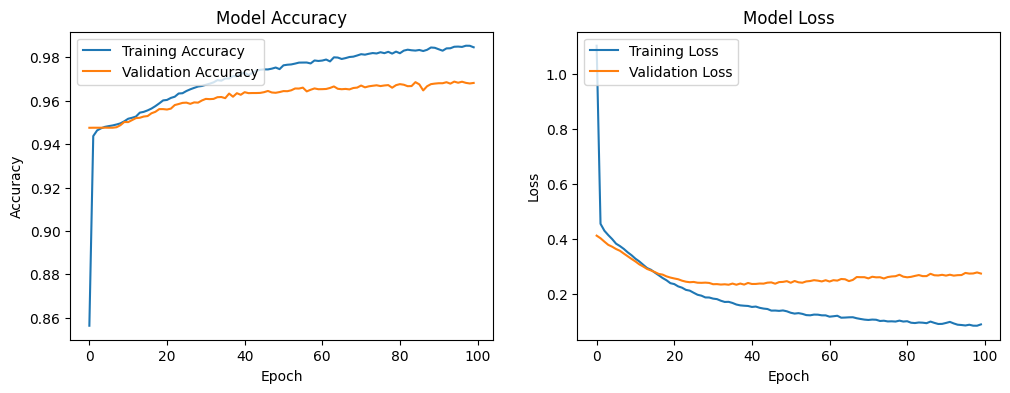

In [29]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 4))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['multi_label_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_multi_label_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()


In [30]:
# Predictions on Test Set
test_predictions = model.predict(X_test)
total_levels = num_level1 + len(parent_map)
combined_output = test_predictions[:, :total_levels]
test_predictions_level1 = (combined_output[:, :num_level1] > 0.5).astype(int)
test_predictions_level2 = (combined_output[:, num_level1:] > 0.5).astype(int)

# Classification Report
print("Classification Report for Level 1:")
print(classification_report(Y_level1_test, test_predictions_level1, target_names=list(level1_to_int.keys())))
print("\nClassification Report for Level 2:")
print(classification_report(Y_level2_test, test_predictions_level2, target_names=list(level2_to_int.keys())))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Classification Report for Level 1:
                          precision    recall  f1-score   support

   Business and Industry       0.66      0.60      0.63       131
family and relationships       0.66      0.49      0.56        59
    fitness and wellness       0.58      0.63      0.61        57
    shopping and fashion       0.84      0.67      0.74       130
                  sports       0.88      0.82      0.85       131
           Entertainment       0.66      0.66      0.66        80
  hobbies and activities       0.80      0.77      0.78       104
              Technology       0.71      0.60      0.65        25
          food and drink       0.92      0.93      0.92        58
                Outdoors       0.82      0.80      0.81        41

               micro avg       0.76      0.70      0.73       816
               macro avg       0.75      0.70      0.72       816
            weighted avg       0.76      0.70      0.73       816

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


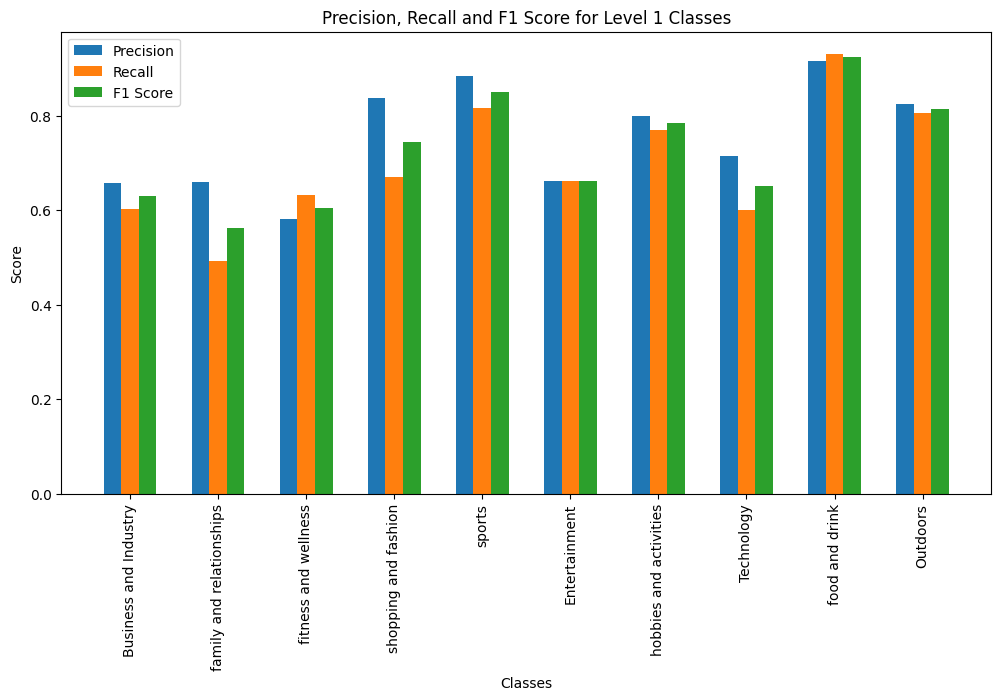

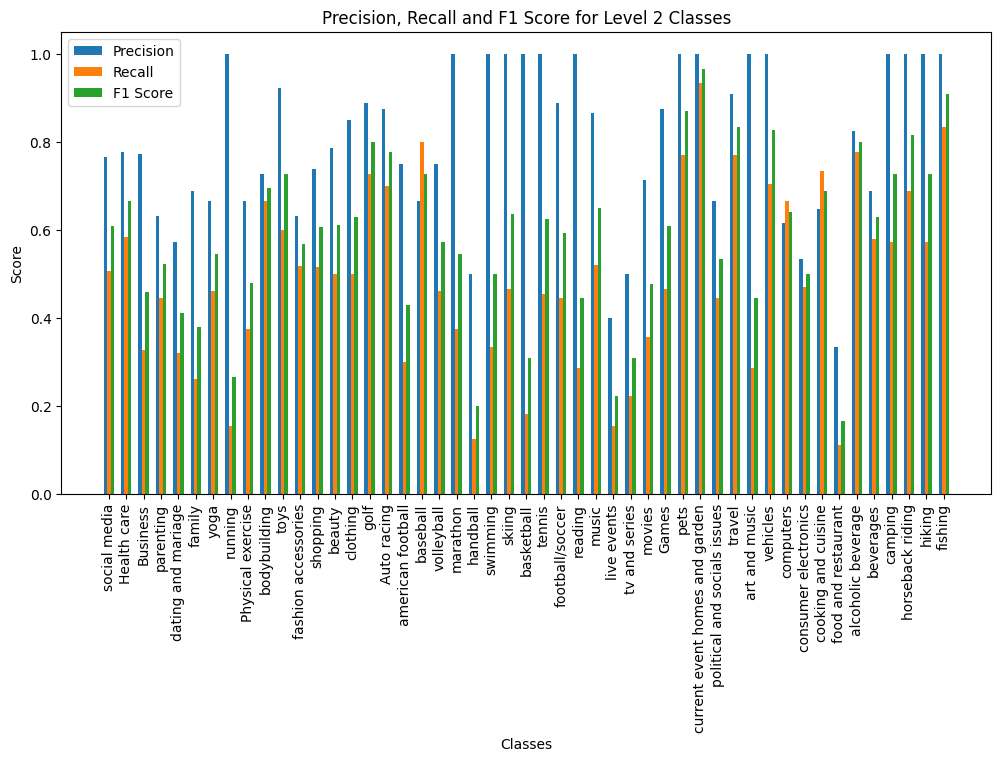

In [31]:
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# Plot F1, Precision, and Recall for Level 1
precision_level1 = precision_score(Y_level1_test, test_predictions_level1, average=None)
recall_level1 = recall_score(Y_level1_test, test_predictions_level1, average=None)
f1_level1 = f1_score(Y_level1_test, test_predictions_level1, average=None)

plt.figure(figsize=(12, 6))
x = np.arange(len(level1_to_int))

plt.bar(x - 0.2, precision_level1, 0.2, label='Precision')
plt.bar(x, recall_level1, 0.2, label='Recall')
plt.bar(x + 0.2, f1_level1, 0.2, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 Score for Level 1 Classes')
plt.xticks(x, list(level1_to_int.keys()), rotation='vertical')
plt.legend(loc='upper left')
plt.show()

# Plot F1, Precision, and Recall for Level 2
precision_level2 = precision_score(Y_level2_test, test_predictions_level2, average=None)
recall_level2 = recall_score(Y_level2_test, test_predictions_level2, average=None)
f1_level2 = f1_score(Y_level2_test, test_predictions_level2, average=None)

plt.figure(figsize=(12, 6))
x = np.arange(len(level2_to_int))

plt.bar(x - 0.2, precision_level2, 0.2, label='Precision')
plt.bar(x, recall_level2, 0.2, label='Recall')
plt.bar(x + 0.2, f1_level2, 0.2, label='F1 Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 Score for Level 2 Classes')
plt.xticks(x, list(level2_to_int.keys()), rotation='vertical')
plt.legend(loc='upper left')
plt.show()